Our goal is to construct a social graph of S&P 500 companies and their interconnectedness through their board members. We'll start from the S&P 500 page at Reuters to obtain a list of symbols: 

In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import networkx as nx
from networkx.readwrite.gexf import write_gexf

In [4]:
session = requests.Session()

In [5]:
sp500 = 'https://www.reuters.com/finance/markets/index/.SPX'

In [6]:
page = 1
regex = re.compile(r'/finance/stocks/overview/.*')
symbols = []

In [7]:
while True:
  print('Scraping page:', page)
  params = params={'sortBy': '', 'sortDir' :'', 'pn': page}
  html = session.get(sp500, params=params).text
  soup = BeautifulSoup(html, "html.parser")
  pagenav = soup.find(class_='pageNavigation')
  if not pagenav:
    break
  companies = pagenav.find_next('table', class_='dataTable')
  for link in companies.find_all('a', href=regex):
    symbols.append(link.get('href').split('/')[-1])
  page += 1

print(symbols)

Scraping page: 1
Scraping page: 2
Scraping page: 3
Scraping page: 4
Scraping page: 5
Scraping page: 6
Scraping page: 7
Scraping page: 8
Scraping page: 9
Scraping page: 10
Scraping page: 11
Scraping page: 12
Scraping page: 13
Scraping page: 14
Scraping page: 15
Scraping page: 16
Scraping page: 17
Scraping page: 18
['MMM.N', 'AOS.N', 'ABT.N', 'ABBV.N', 'ACN.N', 'ATVI.OQ', 'AYI.N', 'ADNT.N', 'ADBE.OQ', 'AMD.OQ', 'AAP.N', 'AES.N', 'AET.N', 'AMG.N', 'AFL.N', 'A.N', 'APD.N', 'AKAM.OQ', 'ALK.N', 'ALB.N', 'ARE.N', 'ALXN.OQ', 'ALGN.OQ', 'ALLE.N', 'AGN.N', 'ADS.N', 'LNT.N', 'ALL.N', 'MO.N', 'AMZN.OQ', 'AEE.N', 'AAL.OQ', 'AEP.N', 'AXP.N', 'AIG.N', 'AMT.N', 'AWK.N', 'AMP.N', 'ABC.N', 'AME.N', 'AMGN.OQ', 'APH.N', 'APC.N', 'ADI.OQ', 'ANDV.N', 'ANSS.OQ', 'ANTM.N', 'AON.N', 'APA.N', 'AIV.N', 'AAPL.OQ', 'AMAT.OQ', 'APTV.N', 'ADM.N', 'ARNC.N', 'AJG.N', 'AIZ.N', 'T.N', 'ADSK.OQ', 'ADP.OQ', 'AZO.N', 'AVGO.OQ', 'AVB.N', 'AVY.N', 'BHGE.N', 'BLL.N', 'BAC.N', 'BK.N', 'BAX.N', 'BBT.N', 'BDX.N', 'BRKb.N', 'BBY.

Once we have obtained a list of symbols, we can visit the board member pages for each of them (e.g. https://www.reuters.com/finance/stocks/company-officers/MMM.N), fetch out the table of board members, and store it as a pandas data frame: 

In [9]:
officers = 'https://www.reuters.com/finance/stocks/company-officers/{symbol}'

In [17]:
symbols = ['AMZN.OQ','AAPL.OQ','GOOG.OQ']
dfs = []

for symbol in symbols:
  print('Scraping symbol:', symbol)
  html = session.get(officers.format(symbol=symbol)).text
  soup = BeautifulSoup(html, "html.parser")
  officer_table = soup.find('table', {"class" : "dataTable"})
  df = pd.read_html(str(officer_table), header=0)[0]
  df.insert(0, 'symbol', symbol)
  dfs.append(df)

df = pd.concat(dfs)
df.to_pickle('data.pkl')

Scraping symbol: AMZN.OQ
Scraping symbol: AAPL.OQ
Scraping symbol: GOOG.OQ


In [18]:
df = pd.read_pickle('data.pkl')

G = nx.Graph()

for row in df.itertuples():
  G.add_node(row.symbol, type='company')
  G.add_node(row.Name,type='officer')
  G.add_edge(row.symbol, row.Name)

write_gexf(G, 'graph.gexf')

The output file can be opened in ([Gephi](https://humanidadesdigitais.org/2013/08/16/analise-e-visualizacao-de-redes-o-gephi/)), filtered, and modified. The following figure shows a snapshot of the egonets of order 3 for Apple, Google, and Amazon, showing that these are indeed connected: 

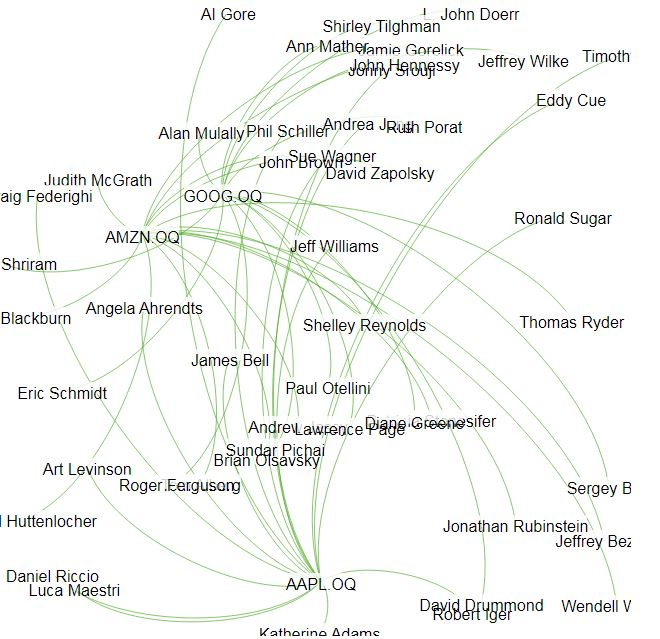